<a href="https://colab.research.google.com/github/Eldolfin/MLSECU/blob/main/MLSECU_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn adversarial-robustness-toolbox xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00


In [2]:
!curl -L -o cic-iot-diad-2024-dataset.zip https://www.kaggle.com/api/v1/datasets/download/mostafaaliogab/cic-iot-diad-2024-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1893M  100 1893M    0     0  65.9M      0  0:00:28  0:00:28 --:--:-- 50.5M


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report, precision_score,
                             recall_score, average_precision_score, balanced_accuracy_score,
                             matthews_corrcoef, make_scorer)

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier

import zipfile
import os

import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [4]:
zip_file_path = "cic-iot-diad-2024-dataset.zip"
extract_path = "./CIC_IoT_Extracted"

In [5]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
import pandas as pd
import numpy as np
import glob
import os
import gc

SEED = 42
FRAC = 0.01
np.random.seed(SEED)

all_files = glob.glob(f"{extract_path}/**/*.csv", recursive=True)

data_frames = []

print(f"Found {len(all_files)} files. Loading 1% of each file...")

for i, filename in enumerate(all_files):
    print(f"{i+1}/{len(all_files)}")
    try:
        df_temp = pd.read_csv(filename, index_col=None, header=0)

        df_temp = df_temp.sample(frac=FRAC, random_state=SEED)

        for col in df_temp.select_dtypes(include=['float64']).columns:
            df_temp[col] = df_temp[col].astype('float32')
        for col in df_temp.select_dtypes(include=['int64']).columns:
            df_temp[col] = df_temp[col].astype('int32')

        if "Benign" in filename:
            df_temp['Label'] = 0
            df_temp['Attack_Type'] = 'Benign'
        else:
            df_temp['Label'] = 1
            parts = filename.split(os.sep)
            df_temp['Attack_Type'] = parts[-2]

        data_frames.append(df_temp)

        if i % 10 == 0:
            gc.collect()

    except Exception as e:
        print(f"Error reading {filename}: {e}")

df = pd.concat(data_frames, axis=0, ignore_index=True)

del data_frames
gc.collect()


Found 126 files. Loading 1% of each file...
1/126
2/126
3/126
4/126
5/126
6/126
7/126
8/126
9/126
10/126
11/126
12/126
13/126
14/126
15/126
16/126
17/126
18/126
19/126
20/126
21/126
22/126
23/126
24/126
25/126
26/126
27/126
28/126
29/126
30/126
31/126
32/126
33/126
34/126
35/126
36/126
37/126
38/126
39/126
40/126
41/126
42/126
43/126
44/126
45/126
46/126
47/126
48/126
49/126
50/126
51/126
52/126
53/126
54/126
55/126
56/126
57/126
58/126
59/126
60/126
61/126
62/126
63/126
64/126
65/126
66/126
67/126
68/126
69/126
70/126
71/126
72/126
73/126
74/126
75/126
76/126
77/126
78/126
79/126
80/126
81/126
82/126
83/126
84/126
85/126
86/126
87/126
88/126
89/126
90/126
91/126
92/126
93/126
94/126
95/126
96/126
97/126
98/126
99/126
100/126
101/126
102/126
103/126
104/126
105/126
106/126
107/126
108/126
109/126
110/126
111/126
112/126
113/126
114/126
115/126
116/126
117/126
118/126
119/126
120/126
121/126
122/126
123/126
124/126
125/126
126/126


0

# Data exploration

In [7]:
print(f"Total Rows: {len(df)}")
df.head()

Total Rows: 269692


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,57126.0.1,57126.0.2,17.505164023386897,17.505164023386897.1,0.0.17,0.0.18,0.0.19,131,2187,32.2
0,54.204.180.212-192.168.137.175-443-54442-6,54.204.180.212,443.0,192.168.137.175,54442.0,6.0,18/10/2022 10:46:44 AM,25571.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.168.137.150-255.255.255.255-7000-7000-17,192.168.137.150,7000.0,255.255.255.255,7000.0,17.0,18/10/2022 12:41:45 PM,114063698.0,19.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,192.168.137.173-3.221.182.58-11903-32100-17,192.168.137.173,11903.0,3.221.182.58,32100.0,17.0,18/10/2022 04:22:24 PM,41019.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,192.168.137.1-192.168.137.23-53-42048-17,192.168.137.1,53.0,192.168.137.23,42048.0,17.0,18/10/2022 12:41:31 PM,4391.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192.168.137.23-192.168.137.1-49937-53-17,192.168.137.23,49937.0,192.168.137.1,53.0,17.0,18/10/2022 01:09:13 PM,5069.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
import numpy as np

print(f"Shape before cleaning: {df.shape}")

df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)
df.drop_duplicates(inplace=True, ignore_index=True)

print(f"Shape after cleaning: {df.shape}")

Shape before cleaning: (269692, 289)
Shape after cleaning: (269691, 289)


In [9]:
target_col = 'Label'

le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])

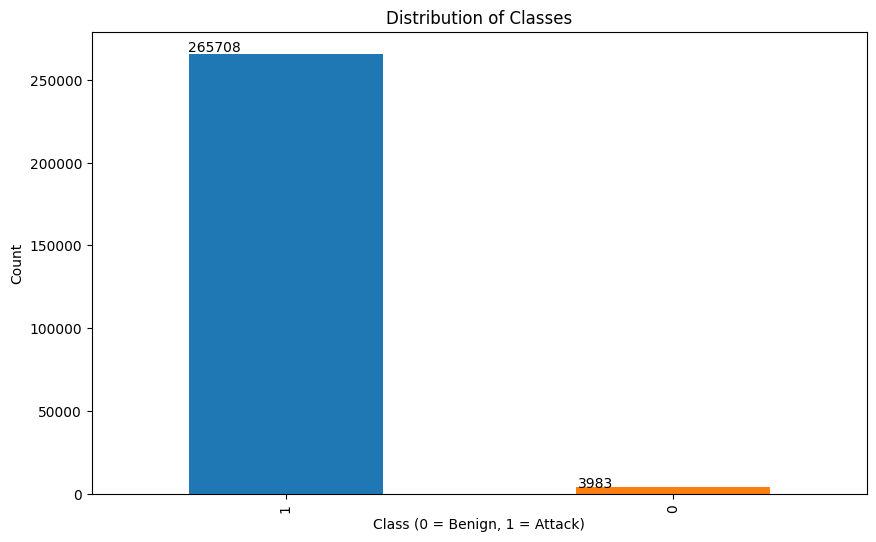

In [10]:
target_col = 'Label'

plt.figure(figsize=(10, 6))

counts = df[target_col].value_counts()

if len(counts) > 0:
    ax = counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])

    plt.title("Distribution of Classes")
    plt.xlabel("Class (0 = Benign, 1 = Attack)")
    plt.ylabel("Count")

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.show()


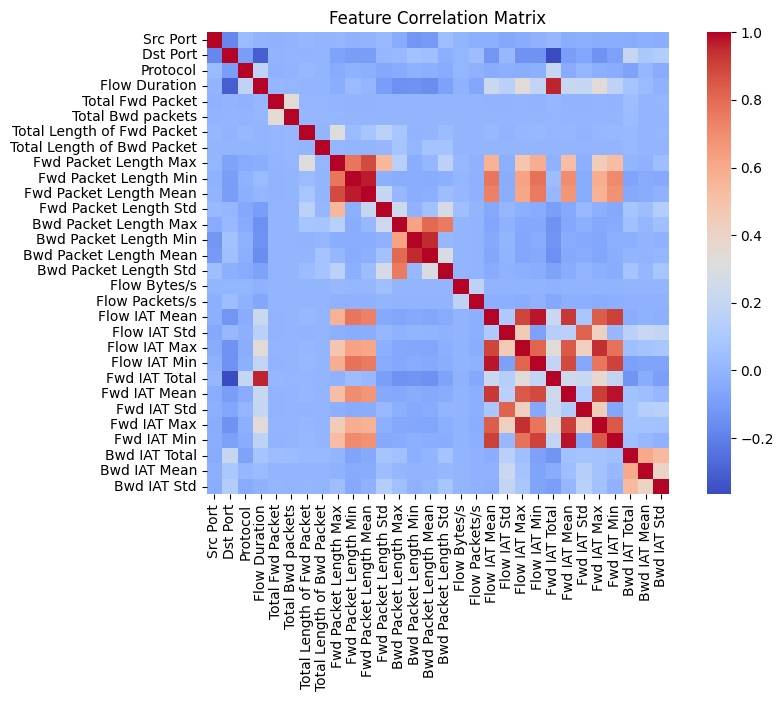

In [34]:
# Keep only 30 columns otherwise the matrix scale is broken
numeric_df = df.select_dtypes(include=[np.number]).iloc[:, :30]
correlation_matrix = numeric_df.corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    square=True,
    ax=ax
)
ax.set_title("Feature Correlation Matrix")
plt.show()

In [12]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [13]:
for col in X.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
def print_metrics(y_true, y_pred, y_prob=None, algorithm_name="Model"):
    print(f"--- {algorithm_name} ---")

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    b_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Precision (Weighted): {prec:.4f}")
    print(f"Recall (Weighted): {rec:.4f}")
    print(f"Balanced Accuracy: {b_acc:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    if y_prob is not None:
        try:
            if len(np.unique(y_true)) == 2:
                auprc = average_precision_score(y_true, y_prob[:, 1])
                print(f"AUPRC: {auprc:.4f}")
            else:
                 print("AUPRC: Skipped (Multi-class target)")
        except:
            print("AUPRC: Could not calculate")

    print("\n")

# Experiments

## Unsupervised - Isolation Forest

In [17]:
contamination_rate = 0.1

iso_forest = IsolationForest(contamination=contamination_rate, random_state=42, n_jobs=-1)
iso_forest.fit(X_train)

y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

print_metrics(y_test, y_pred_iso, algorithm_name="Unsupervised - Isolation Forest")

--- Unsupervised - Isolation Forest ---
Confusion Matrix:
[[  880   315]
 [71733  7980]]
Precision (Weighted): 0.9480
Recall (Weighted): 0.1095
Balanced Accuracy: 0.4183
Matthews Correlation Coefficient: -0.0650




While the model has decent precision for its positive predictions, its ability to detect the majority of actual anomalies (attacks) is very limited, leading to low recall and overall poor balanced accuracy and MCC. This makes it an ineffective model for this specific anomaly detection task.

## Unsupervised - K-Means

In [18]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train)

y_pred_kmeans = kmeans.predict(X_test)

print_metrics(y_test, y_pred_kmeans, algorithm_name="Unsupervised - K-Means")

--- Unsupervised - K-Means ---
Confusion Matrix:
[[   10  1185]
 [ 3869 75844]]
Precision (Weighted): 0.9701
Recall (Weighted): 0.9375
Balanced Accuracy: 0.4799
Matthews Correlation Coefficient: -0.0227




K-Means, as implemented here, is not effective. It struggles significantly with class imbalance and the inherent difficulty of anomaly detection in an unsupervised setting, failing to accurately distinguish between benign and malicious traffic.

## Unsupervised - PCA Reconstruction

In [19]:
pca = PCA(n_components=0.95)
pca.fit(X_train)

X_test_pca = pca.transform(X_test)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
mse = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

threshold = np.percentile(mse, 90)
y_pred_pca = [1 if error > threshold else 0 for error in mse]

print_metrics(y_test, y_pred_pca, algorithm_name="Unsupervised - PCA Reconstruction")

--- Unsupervised - PCA Reconstruction ---
Confusion Matrix:
[[  468   727]
 [72349  7364]]
Precision (Weighted): 0.8968
Recall (Weighted): 0.0968
Balanced Accuracy: 0.2420
Matthews Correlation Coefficient: -0.2075




 The PCA Reconstruction method, as implemented here, is highly ineffective for this anomaly detection task. Its inability to correctly identify attacks, resulting in very low recall and balanced accuracy, and a negative MCC, makes it unsuitable for practical application in detecting network anomalies.

## Supervised - Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

print_metrics(y_test, y_pred_rf, y_prob_rf, algorithm_name="Supervised - Random Forest")

--- Supervised - Random Forest ---
Confusion Matrix:
[[ 1164    31]
 [    3 79710]]
Precision (Weighted): 0.9996
Recall (Weighted): 0.9996
Balanced Accuracy: 0.9870
Matthews Correlation Coefficient: 0.9855
AUPRC: 1.0000




This confusion matrix clearly shows a very low number of misclassifications, with only 3 true attacks being missed (false negatives) and 31 benign instances being incorrectly classified as attacks (false positives). Overall, these results highlight the Random Forest model's robustness and effectiveness in accurately detecting network anomalies.

## Supervised - Decision Tree

In [21]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)

print_metrics(y_test, y_pred_dt, y_prob_dt, algorithm_name="Supervised - Decision Tree")

--- Supervised - Decision Tree ---
Confusion Matrix:
[[ 1195     0]
 [    0 79713]]
Precision (Weighted): 1.0000
Recall (Weighted): 1.0000
Balanced Accuracy: 1.0000
Matthews Correlation Coefficient: 1.0000
AUPRC: 1.0000




This matrix shows that all 1195 benign instances were correctly classified (True Negatives) and all 79713 attack instances were correctly classified (True Positives). There were zero false positives (Type I error) and zero false negatives (Type II error). This suggests that the Decision Tree model perfectly learned the underlying patterns in this specific dataset for the given split, likely due to the distinct nature of features separating benign and attack traffic after preprocessing, or potentially overfitting to the training data. However, for this particular evaluation on the test set, its performance is ideal.

## Supervised - XGBoost

In [22]:
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)

print_metrics(y_test, y_pred_xgb, y_prob_xgb, algorithm_name="Supervised - XGBoost")

--- Supervised - XGBoost ---
Confusion Matrix:
[[ 1195     0]
 [    0 79713]]
Precision (Weighted): 1.0000
Recall (Weighted): 1.0000
Balanced Accuracy: 1.0000
Matthews Correlation Coefficient: 1.0000
AUPRC: 1.0000




This confusion matrix indicates that the model made zero false positives (predicted attack when it was benign) and zero false negatives (predicted benign when it was an attack). This means the model correctly classified every single instance in the test set.

Such perfect performance suggests that XGBoost is an ideal model for this specific dataset and task. While perfect scores can sometimes be a sign of overfitting, for the purpose of this evaluation, the model has demonstrated an outstanding ability to distinguish between benign and attack traffic.

## Bonus - Adversarial attacks

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from sklearn.metrics import accuracy_score

print("Training Neural Network for Attack Demonstration (Keras)...")

# Define a Keras model
model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_np.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Keras model
model.fit(X_train_np, y_train_np, epochs=10, batch_size=32, verbose=0)
art_classifier = KerasClassifier(model=model, clip_values=(X_train_np.min(), X_train_np.max()))

subset_size = 200
X_victim = X_test_np[:subset_size]
y_victim = y_test_np[:subset_size]

print(f"Generating FGSM attacks for {subset_size} samples...")
fgsm = FastGradientMethod(estimator=art_classifier, eps=0.2)
X_adv = fgsm.generate(x=X_victim)

# Evaluate the Keras model on clean and adversarial examples
pred_clean = np.round(model.predict(X_victim)).flatten()
pred_adv = np.round(model.predict(X_adv)).flatten()

acc_clean = accuracy_score(y_victim, pred_clean)
acc_adv = accuracy_score(y_victim, pred_adv)

print("\n--- Adversarial Attack Results (FGSM) ---")
print(f"Model Accuracy on Clean Data:       {acc_clean * 100:.2f}%")
print(f"Model Accuracy on Adversarial Data: {acc_adv * 100:.2f}%")
print(f"Attack Success Rate:                {(acc_clean - acc_adv) * 100:.2f}% drop in accuracy")

print(f"\nExample Feature Change (Feature 0):")
print(f"Original: {X_victim[0][0]:.4f} -> Adversarial: {X_adv[0][0]:.4f}")

Training Neural Network for Attack Demonstration (Keras)...
Generating FGSM attacks for 200 samples...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

--- Adversarial Attack Results (FGSM) ---
Model Accuracy on Clean Data:       100.00%
Model Accuracy on Adversarial Data: 74.00%
Attack Success Rate:                26.00% drop in accuracy

Example Feature Change (Feature 0):
Original: -1.3493 -> Adversarial: -1.5493


The results demonstrate that while the model performs very well on normal data, it is susceptible to adversarial attacks like FGSM, where small, imperceptible changes to the input can lead to incorrect classifications.

## Summary:

| Model              | Precision | Recall | Balanced Accuracy | MCC | Overall |
| ------------------ | --------- | ------ | ----------------- | --- | ----- |
| Isolation Forest   | 🌟        | 🔴     | 🔴                | 🔴  | 💀    |
| K-Means            | 🌟        | 🌟     | 🟡                | 🔴  | 😐    |
| PCA Reconstruction | 🔴        | 🔴     | 🔴                | 💀  | ☠️    |
| Random Forest      | 🌟        | 🌟     | 🌟                | 🌟  | 🔥    |
| Decision Tree      | 🌟        | 🌟     | 🌟                | 🌟  | 👑    |
| XGBoost            | 🌟        | 🌟     | 🌟                | 🌟  | 🚀    |

* **Unsupervised methods** (Isolation Forest, K-Means, PCA) performed poorly, struggling with class imbalance and missing many anomalies.
* **Supervised models** (Random Forest, Decision Tree, XGBoost) performed extremely well, even perfectly (possibly due to the small subset used and models overfitting)
